## Обучение без учителя

Семинар взят из курса ИАД

## Часть 1. Метод главных компонент (Principal Component Analysis, PCA).

Понижать размерность может быть полезно, чтобы: 
- бороться с «проклятием размерности»
- генерировать новые, более информативные признаки
- строить более простые и менее ресурсоемкие модели

Один из самых простых и понятных методов, которые используют для понижения размерности, — это метод главных компонент (PCA).

#### Теория

Кратко вспомним, что делает этот метод.

Пусть $X$ &mdash; матрица объекты-признаки размера $n \times D$, с нулевым средним каждого признака. 
Мы хотим перейти в новое признаковое пространство размерности $n \times d$, $d<D$,  сохранив при этом как можно больше информации из исходного набора данных.

Введем некоторый вектор весов $w$. Тогда
$Xw$ задает величину проекций всех объектов на этот вектор. Нам нужно найти вектор $w$, 
который дает наибольшую дисперсию полученных проекций (что связано с нашим желанием потерять как можно меньше информации при переходе в новое пространство).
Формально задачку можно записать так: 

$$
    \max_{w: \|w\|=1} \| Xw \|^2 =  \max_{w: \|w\|=1} w^T X^T X w
$$

Можно показать, что решением задачи является собственный вектор матрицы $X^T X$ с наибольшим собственным
значением. Мы получили первую главную компоненту. Чтобы получить $d$ компонент, придется повторить этот процесс $d$ раз, каждый последующий раз накладывая ограничение на ортогональность искомой компоненты всем, найденным на предыдущих шагах. Затем можно посчитать проекции матрицы $X$ на каждую из компонент и таким образом перейти в новое признаковое пространство.

#### PCA на плоскости

Для начала посмотрим на метод PCA на плоскости.

Попробуем специально сделать один из признаков более значимым (имеющим больший разброс значений) и проверим, что PCA это обнаружит. Сгенерируем выборку из двухмерного гауссовского распределения. Обратите внимание, что выборка
изначально выбирается центрированной.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
np.random.seed(314512)

data_synth_1 = np.random.multivariate_normal(
    mean=[0, 0], 
    cov=[[4, 0], 
         [0, 1]],
    size=1000)

Теперь изобразим точки выборки на плоскости и применим к ним PCA для нахождения главных компонент.
В результате работы PCA из sklearn в `dec.components_` будут лежать главные направления (нормированные), а в `dec.explained_variance_` &mdash; дисперсия, которую объясняет каждая компонента. Изобразим на нашем графике эти направления, умножив их на дисперсию для наглядного отображения их
значимости.

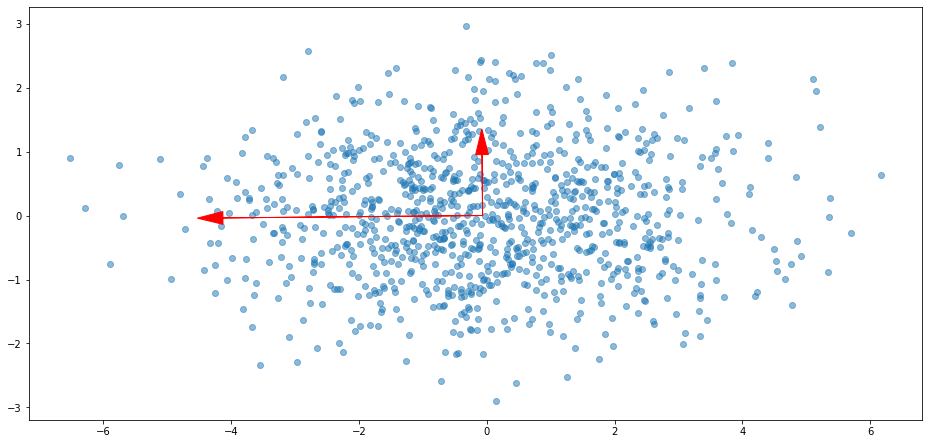

In [3]:
from sklearn.decomposition import PCA


def PCA_show(dataset):
    plt.scatter(*zip(*dataset), alpha=0.5)
    
    dec = PCA()
    dec.fit(dataset)
    ax = plt.gca()
    for comp_ind in range(dec.components_.shape[0]):
        component = dec.components_[comp_ind, :]
        var = dec.explained_variance_[comp_ind]
        start, end = dec.mean_, component * var
        ax.arrow(start[0], start[1], end[0], end[1],
                 head_width=0.2, head_length=0.4, fc='r', ec='r')
    
    ax.set_aspect('equal', adjustable='box')

plt.figure(figsize=(16, 8))
PCA_show(data_synth_1)

Видим, что PCA правильно определил направление наибольшего разброса данных. Но это, конечно, можно было сделать, просто посчитав
дисперсию каждого признака. Повернем наши данные на некоторый фиксированный угол и проверим,
что для PCA это ничего не изменит.

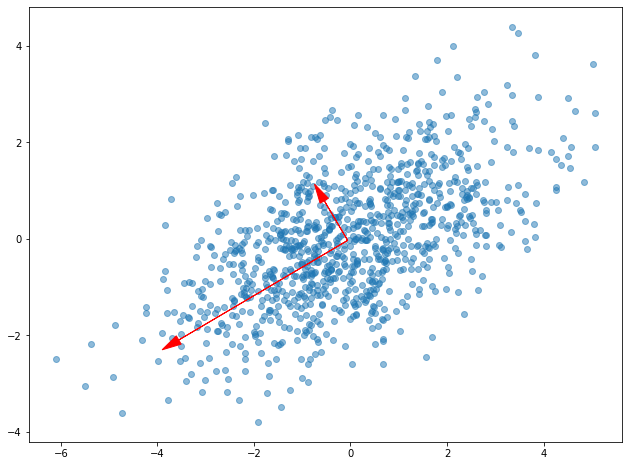

In [4]:
angle = np.pi / 6
rotate = np.array([
        [np.cos(angle), - np.sin(angle)],
        [np.sin(angle), np.cos(angle)],
    ])
data_synth_2 = rotate.dot(data_synth_1.T).T

plt.figure(figsize=(16, 8))
PCA_show(data_synth_2)

Ниже пара примеров, где PCA отработал не так хорошо (в том смысле, что направления задают не очень хорошие признаки, не отображающие структуру данных).

**Упражнение.** Объясните, почему так произошло.

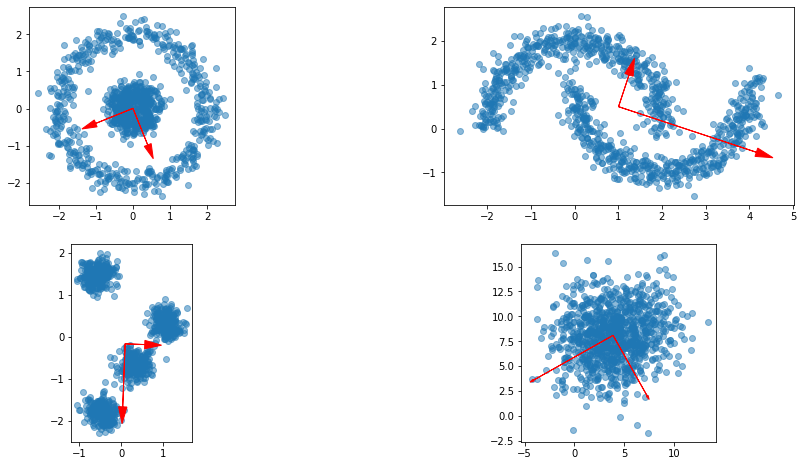

In [5]:
from sklearn.datasets import make_circles, make_moons, make_blobs

np.random.seed(54242)
data_synth_bad = [
    make_circles(n_samples=1000, factor=0.2, noise=0.1)[0]*2,
    make_moons(n_samples=1000, noise=0.1)[0]*2,
    make_blobs(n_samples=1000, n_features=2, centers=4)[0]/5,
    np.random.multivariate_normal(
        mean=[4, 8], 
        cov=[[9, 1], 
             [1, 8]],
        size=1000),
]


plt.figure(figsize=(16,8))
rows, cols = 2, 2
for i, data in enumerate(data_synth_bad):
    plt.subplot(rows, cols, i + 1)
    PCA_show(data)

#### Лица людей

Рассмотрим датасет с фотографиями лиц людей и применим к его признакам PCA.

Ниже изображены примеры лиц из базы, а последняя картинка &mdash; это "среднее лицо".

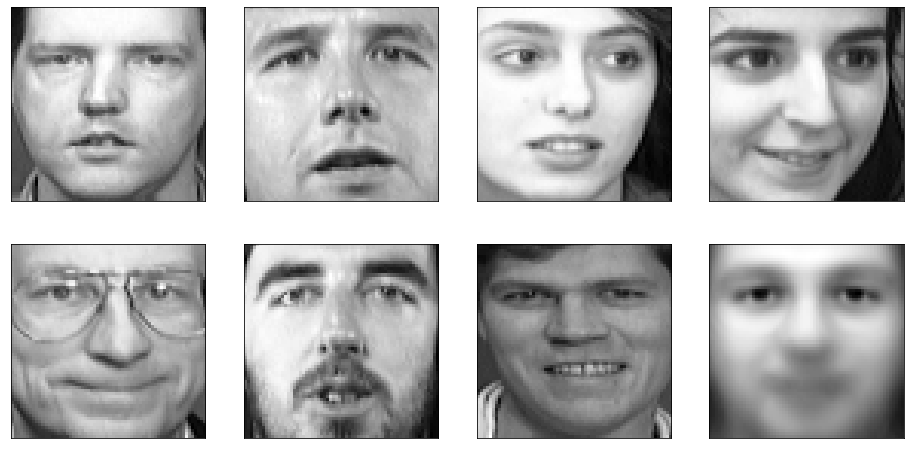

In [6]:
from sklearn.datasets import fetch_olivetti_faces

faces = fetch_olivetti_faces(shuffle=True, random_state=432542)
faces_images = faces.data
faces_ids = faces.target
image_shape = (64, 64)
    
mean_face = faces_images.mean(axis=0)

plt.figure(figsize=(16, 8))
rows, cols = 2, 4
n_samples = rows * cols
for i in range(n_samples - 1):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(faces_images[i, :].reshape(image_shape), interpolation='none',
               cmap='gray')
    plt.xticks(())
    plt.yticks(())
    
plt.subplot(rows, cols, n_samples)
plt.imshow(mean_face.reshape(image_shape), interpolation='none',
           cmap='gray')
plt.xticks(())
_ = plt.yticks(())

Теперь найдем главные компоненты.

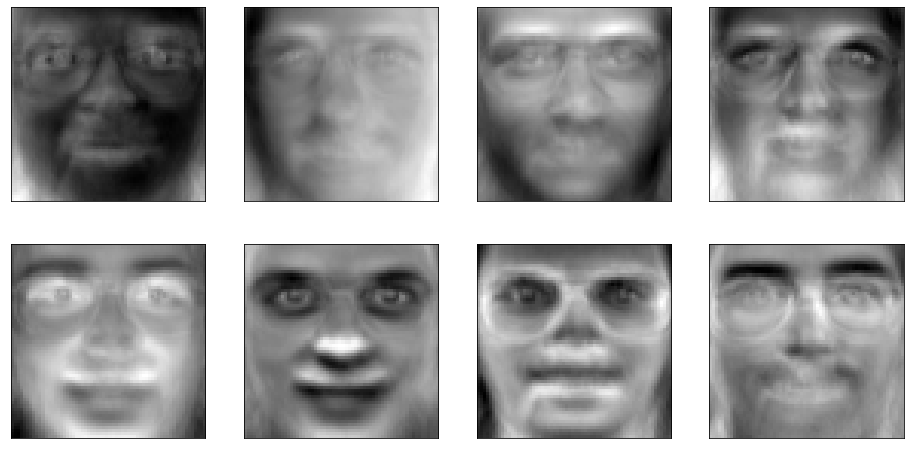

In [7]:
red = PCA()
faces_images -= mean_face
red.fit(faces_images)

plt.figure(figsize=(16, 8))
rows, cols = 2, 4
n_samples = rows * cols
for i in range(n_samples):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(red.components_[i, :].reshape(image_shape), interpolation='none',
               cmap='gray')
    plt.xticks(())
    plt.yticks(())

Получилось жутковато, что уже неплохо, но есть ли от этого какая-то польза?

Во-первых, новые признаки дают более высокое качество классификации.

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

gscv_rf = GridSearchCV(RandomForestClassifier(),
                       {'n_estimators': [100, 200, 500, 800], 'max_depth': [2, 3, 4, 5]},
                       cv=3)

In [9]:
%%time

gscv_rf.fit(faces_images, faces_ids)
print(gscv_rf.best_score_)

0.7547600344143942
CPU times: user 1min 51s, sys: 1.94 s, total: 1min 53s
Wall time: 2min 7s


In [10]:
%%time

gscv_rf.fit(red.transform(faces_images)[:,:100], faces_ids)
print(gscv_rf.best_score_)

0.8973553286200575
CPU times: user 52.6 s, sys: 1.16 s, total: 53.8 s
Wall time: 1min 1s


На практике можно выбирать столько главных компонент, чтобы оставить $90\%$ дисперсии исходных данных. В данном случае для этого достаточно выделить около $60$ главных компонент, то есть снизить размерность с $4096$ признаков до $60$.

In [ ]:
faces_images.shape

(400, 4096)

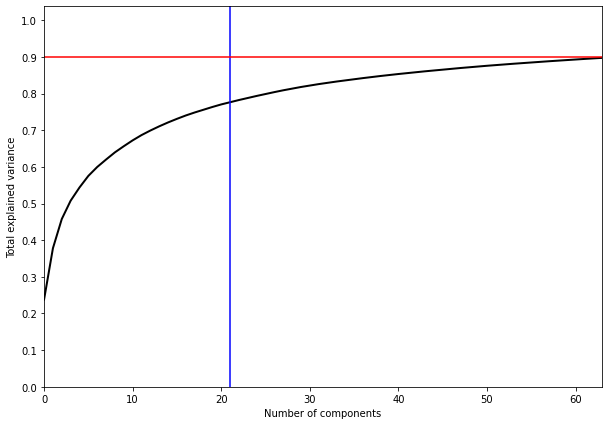

In [ ]:
plt.figure(figsize=(10,7))
plt.plot(np.cumsum(model_pca.explained_variance_ratio_), color='k', lw=2)
plt.xlabel('Number of components')
plt.ylabel('Total explained variance')
plt.xlim(0, 63)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.axvline(21, c='b')
plt.axhline(0.9, c='r')
plt.show();

Во-вторых, их можно использовать для компактного хранения данных. Для этого объекты трансформируются
в новое пространство, и из него выкидываются самые незначимые признаки.

Ниже приведены результаты сжатия в 10 раз.

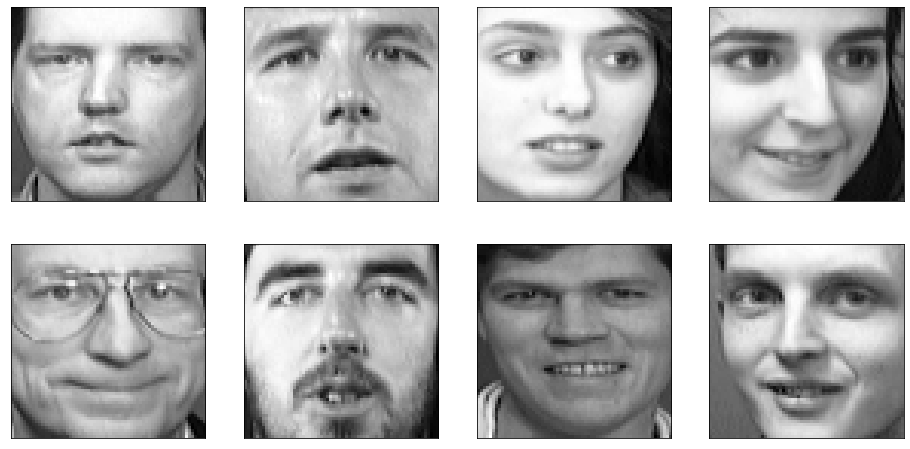

In [11]:
base_size = min(image_shape[0] * image_shape[1], faces_images.shape[0])

def compress_and_show(compress_ratio):
    red = PCA(n_components=int(base_size * compress_ratio))
    red.fit(faces_images)

    faces_compressed = red.transform(faces_images)
    faces_restored = red.inverse_transform(faces_compressed) + mean_face

    plt.figure(figsize=(16, 8))
    rows, cols = 2, 4
    n_samples = rows * cols
    for i in range(n_samples):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(faces_restored[i, :].reshape(image_shape), interpolation='none',
                   cmap='gray')
        plt.xticks(())
        plt.yticks(())
        
compress_and_show(1)

И даже при сжатии в 20 раза лица остаются узнаваемыми.

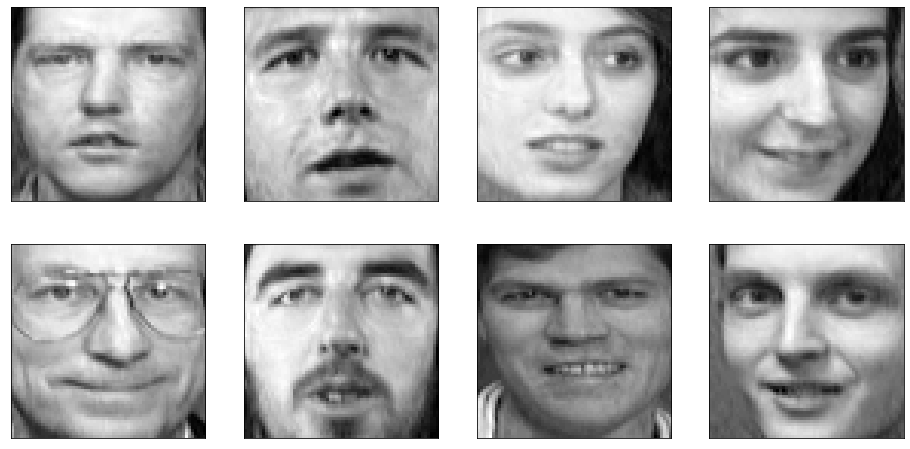

In [15]:
compress_and_show(0.5)

## Часть 2. Кластеризация

### 1. K-средних

Напомним что сам алгоритм можно схематически представить в виде следующих шагов:

1. Инициализируем центры кластеров случайно (должно быть задано количество кластеров).
2. Относим точки к соответствующим кластерам (с минимальным расстоянием до их центра).
3. Производится пересчет центров кластеров по формуле центра масс всех точек принадлежащих кластеру.
4. Пункты 2-3 повторяются до тех пор пока центры кластеров перестанут меняться (сильно).

Посмотрим на то, как работает этот алгоритм на игрушечных данных. 

In [ ]:
from sklearn.cluster import KMeans

np.random.seed(123)
X1 = np.random.randn(100,2)
X2 = np.random.randn(100,2) - np.array([10,1])
X3 = np.random.randn(100,2) - np.array([1,10])
X = np.vstack((X1,X2,X3))
y = np.array([1]*100 + [2]*100 + [3]*100)

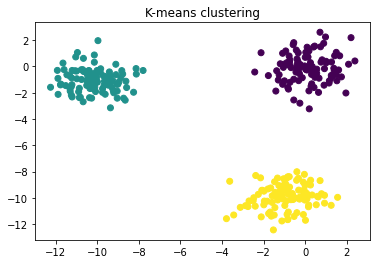

In [ ]:
k_means = KMeans(n_clusters = 3)
k_means = k_means.fit(X)
clusters = k_means.predict(X)

plt.scatter(X[:,0], X[:,1], c = clusters)
plt.title('K-means clustering');

Посмотрим что будет происходить если мы не угадали с числом кластеров.

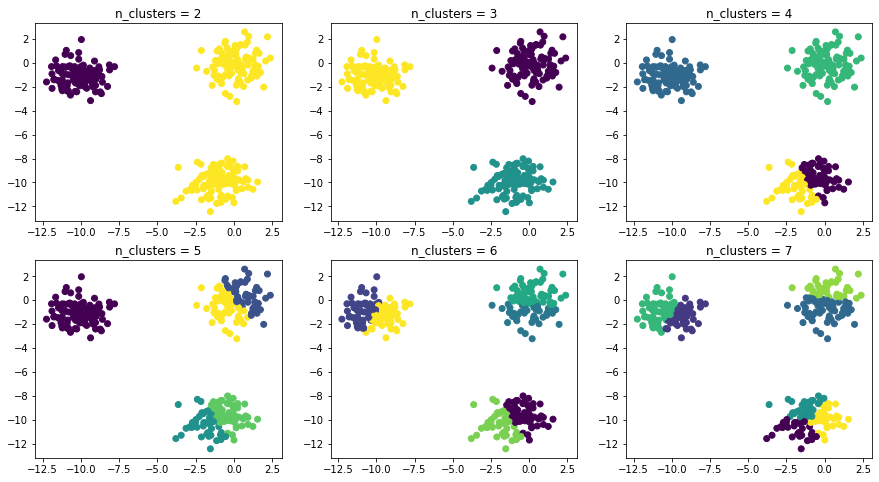

In [ ]:
plt.figure(figsize= (15,8))
for n_c in range(2,8):
    k_means = KMeans(n_clusters = n_c)
    k_means = k_means.fit(X)
    clusters = k_means.predict(X)
    plt.subplot(2,3, n_c - 1)
    plt.scatter(X[:,0], X[:,1], c = clusters)
    plt.title('n_clusters = {}'.format(n_c))

- Один из главных недостатков k-means является случайная инициализация центров кластеров, что может привести к различным результатам кластеризации.
- Главным же достоинством является скорость алгоритма. На каждой итерации требуется пересчет только расстояний до центров кластеров.
- Как мы видим k-means обязательно пытается отдать каждому кластеру какие-то объекты и, как большинство алгоритмов кластеризации зависит от заданного числа кластеров. Число кластеров в k-means можно подбирать. Но тут будут небольшие проблемы.

[Визуализация работы K-Means](https://www.naftaliharris.com/blog/visualizing-k-means-clustering/)

В отличие от задачи классификации или регресии, в случае кластеризации сложнее выбрать критерий, с помощью которого было бы просто представить задачу кластеризации как задачу оптимизации. В случае kMeans распространен вот такой критерий – сумма квадратов расстояний от точек до центроидов кластеров, к которым они относятся.

$$ 
J(C) = \sum_{k=1}^K\sum_{i~\in~C_k} ||x_i - \mu_k|| \rightarrow \min\limits_C,
$$

здесь $C$ – множество кластеров мощности $K$, $\mu_k$ – центроид кластера $C_k$.

__Здравый смысл в этом есть:__ мы хотим, чтобы точки распологались кучно возле центров своих кластеров. Но вот незадача: минимум такого фнукционала будет достигаться тогда, когда кластеров столько же, сколько и точек (то есть каждая точка – это кластер из одного элемента).

Для решения этого вопроса (выбора числа кластеров) часто пользуются такой эвристикой: выбирают то число кластеров, начиная с которого описанный функционал $ J(C) $ падает "уже не так быстро". Или более формально говоря 


$$
Q(k) = \frac{|J(C_k) - J(C_{k+1})|}{|J(C_{k-1}) - J(C_{k})| } \to \min_{k}
$$






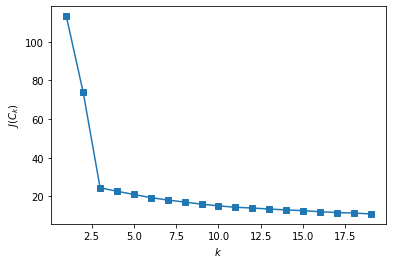

In [ ]:
from sklearn import metrics 
from scipy.spatial.distance import cdist

rg = range(1, 20)
inertia = []
for k in rg:
    kmeans = KMeans(n_clusters=k, random_state=1).fit(X)
    inertia.append(np.sqrt(kmeans.inertia_))
    
plt.plot(rg, inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');

Видно, что для нашего примера трёх кластеров достаточно. Есть огромное количество других способов выбирать количество кластеров автоматически, например можно ввести вероятностный подход к выбору числа кластеров (очень похоже на EM-алгоритм с автоматическим выбором количества компонент). 

#### Кластеризуем пиксели

Применим наш метод кластеризации к сегментации изображений. Для этого загрузим картинку и будем каждый ее пиксель рассматривать как отдельный объект с тремя признаками R G B, отвечающими за цвет пикселя. Нам понадобится изменить форму тензора с изображением, вытянув все пиксели вдоль одной оси, чтобы получить матрицу объекты-признаки.

In [29]:
img = plt.imread('https://raw.githubusercontent.com/iad34/seminars/master/materials/apple.png')
img.shape

(237, 316, 3)

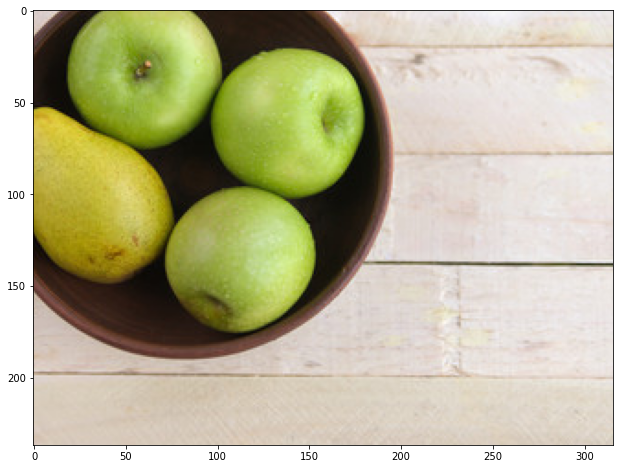

In [30]:
plt.imshow(img)

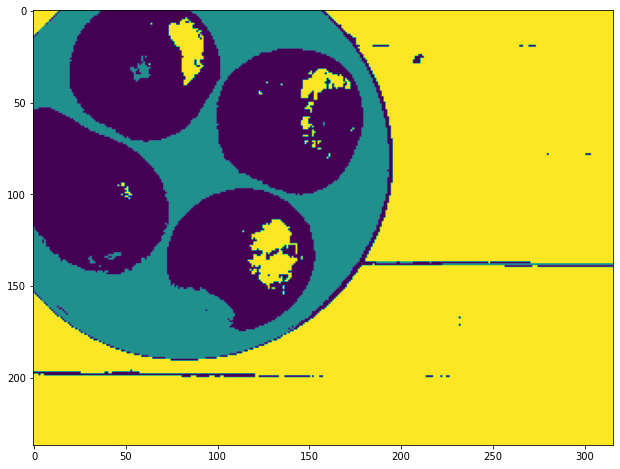

In [31]:
X = img.reshape(-1, 3)
cls = k_means(3)
cls.fit(X)
y = cls.transform(X)
plt.imshow(y.reshape(img.shape[:2]))

Обратите внимание, что при кластеризации никак не учитывалась информация о положении пикселя на изображении, а учитывался только цвет.

**Опциональное задание:** добавьте к трем уже использующимся признакам (RGB) признаки-координаты пикселя. Можно поэкспериментировать с метриками (например, домножать признаки-координаты на какой-то вес-гиперпараметр).

### 2. DBSCAN

(Density-based spatial clustering of applications with noise)

Это алгоритм, основанный на плотности — если дан набор объектов в некотором пространстве, алгоритм группирует вместе объекты, которые расположены близко и помечает как выбросы объекты, которые находятся в областях с малой плотностью (ближайшие соседи которых лежат далеко).

Алгоритм имеет два основных гиперпараметра:
1. `eps` &mdash; радиус рассматриваемой окрестности
2. `min_samples` &mdash; число соседей в окрестности

Для выполнения кластеризации DBSCAN точки делятся на основные точки, достижимые по плотности точки и выпадающие следующим образом:

- Точка $p$ является основной точкой, если по меньшей мере `min_samples` точек находятся на расстоянии, не превосходящем 
`eps` от неё. Говорят, что эти точки достижимы прямо из $p$.

-  Точка $q$ прямо достижима из $p$, если точка $q$ находится на расстоянии, не большем `eps`, от точки $p$, и $p$ — основная точка.
Точка $q$ достижима из $p$, если имеется путь 
$p_1,…,p_n$ где $p_1=p$ и $p_n=q$ , а каждая точка $p_{i+1}$ достижима прямо из $p_i$ (все точки на пути должны быть основными, за исключением $q$).

Все точки, не достижимые из основных точек, считаются выбросами.

Теперь, если $p$ является основной точкой, то она формирует кластер вместе со всеми точками (основными или неосновными), достижимыми из этой точки. Каждый кластер содержит по меньшей мере одну основную точку. Неосновные точки могут быть частью кластера, но они формируют его «край», поскольку не могут быть использованы для достижения других точек.



Рассмотрим диаграмму, параметр `min_samples`=4.

Точка $A$ и другие красные точки являются основными точками, поскольку область с радиусом 
`eps` , окружающая эти точки, содержит по меньшей мере 4 точки (включая саму точку). Поскольку все они достижимы друг из друга, точки образуют один кластер. Точки $B$ и $C$ основными не являются, но достижимы из $A$ (через другие основные точки), и также принадлежат кластеру. Точка $N$ является точкой шума, она не является ни основной точкой, ни доступной прямо.

<p><a href="https://commons.wikimedia.org/wiki/File:DBSCAN-Illustration.svg#/media/Файл:DBSCAN-Illustration.svg"><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/a/af/DBSCAN-Illustration.svg/1200px-DBSCAN-Illustration.svg.png" alt="DBSCAN-Illustration.svg" width="450" height="450"> </a><br>Автор: <a href="//commons.wikimedia.org/wiki/User:Chire" title="User:Chire">Chire</a> &mdash; <span class="int-own-work" lang="ru">собственная работа</span>, <a href="https://creativecommons.org/licenses/by-sa/3.0" title="Creative Commons Attribution-Share Alike 3.0">CC BY-SA 3.0</a>

Посмотрим на результаты кластеризации при разном выборе параметров `eps` и `min_samples`.

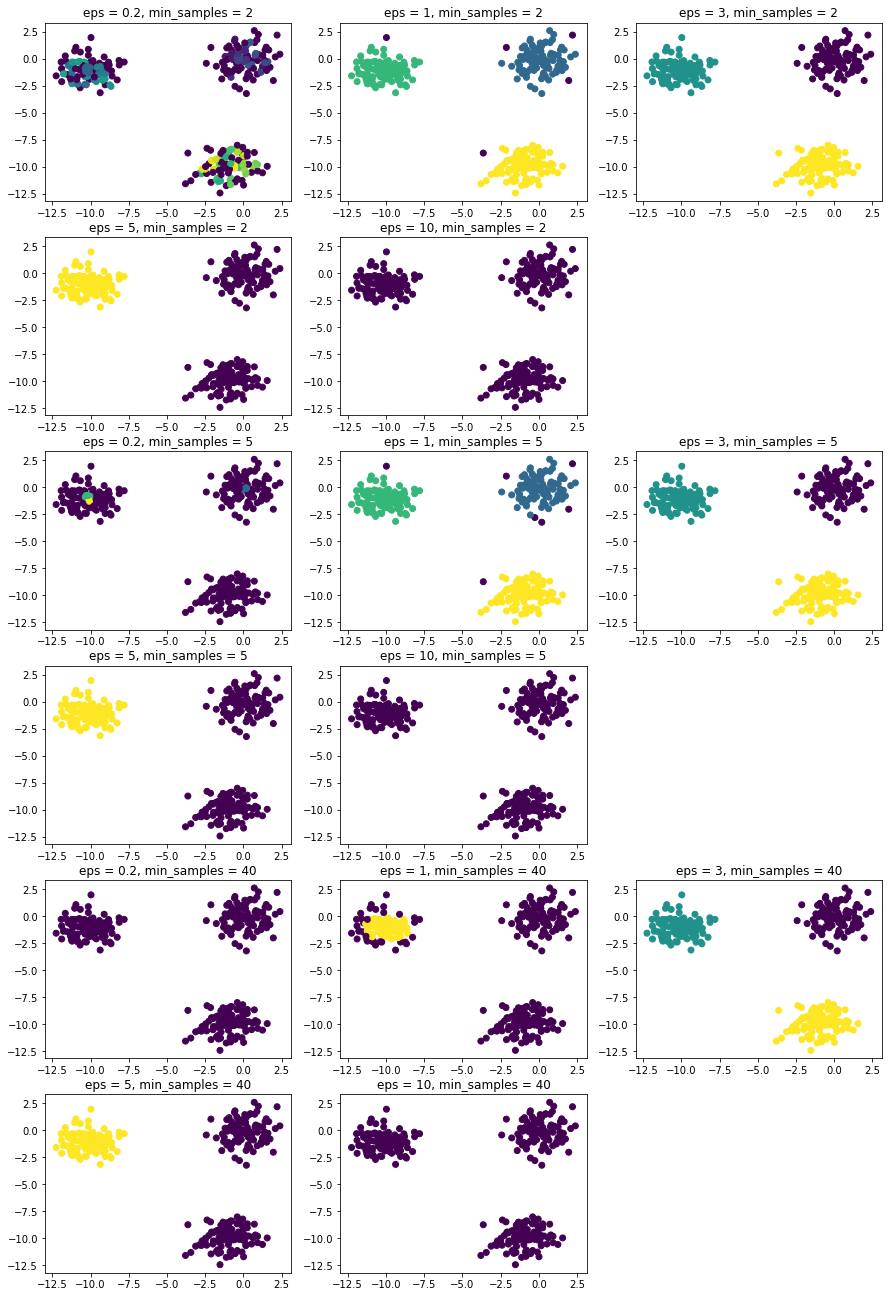

In [7]:
from sklearn.cluster import DBSCAN
plt.figure(figsize= (15,23))
i = 1
for samples in [2, 5, 40]:
    for e in [0.2, 1, 3, 5, 10]:
        dbscan = DBSCAN(eps=e, min_samples=samples)
        clusters = dbscan.fit_predict(X)
        plt.subplot(6, 3, i)
        plt.scatter(X[:,0], X[:,1], c = clusters)
        plt.title('eps = {}, min_samples = {}'.format(e, samples))
        i += 1
    i+=1

plt.show()

[Визуализация работы DBSCAN](https://www.naftaliharris.com/blog/visualizing-dbscan-clustering/)
(Стоит посмотреть)

Результаты работы методов на других датасетах:

In [8]:
from sklearn.datasets import make_moons, make_circles

In [9]:
X, y = make_moons(n_samples=500, noise=0.1)

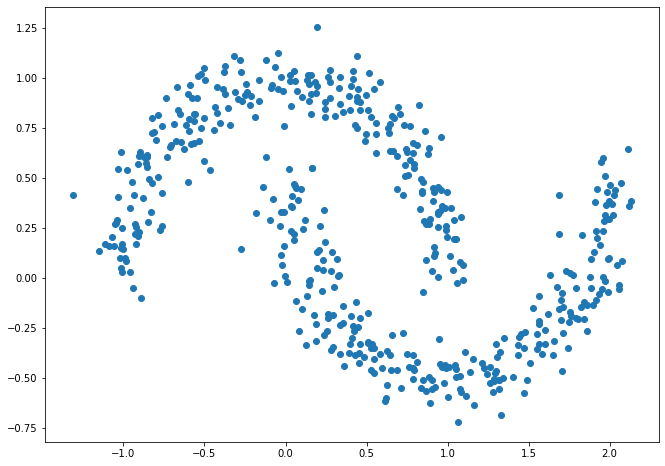

In [10]:
plt.scatter(X[:,0], X[:,1])
plt.show()

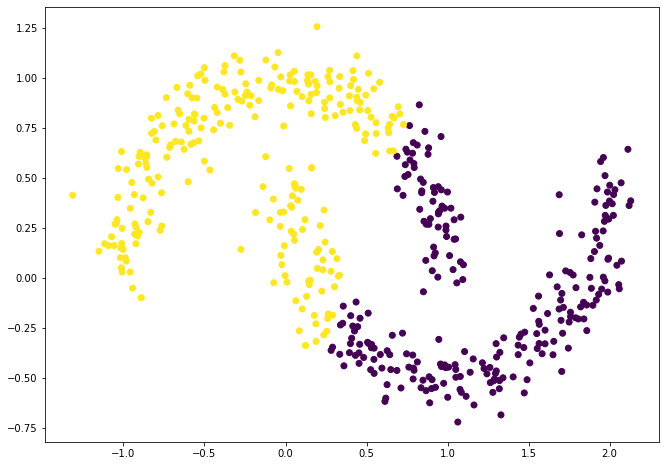

In [11]:
k_means = KMeans(n_clusters = 2)
k_means = k_means.fit(X)
clusters = k_means.predict(X)
plt.scatter(X[:,0], X[:,1], c=clusters)
plt.show()

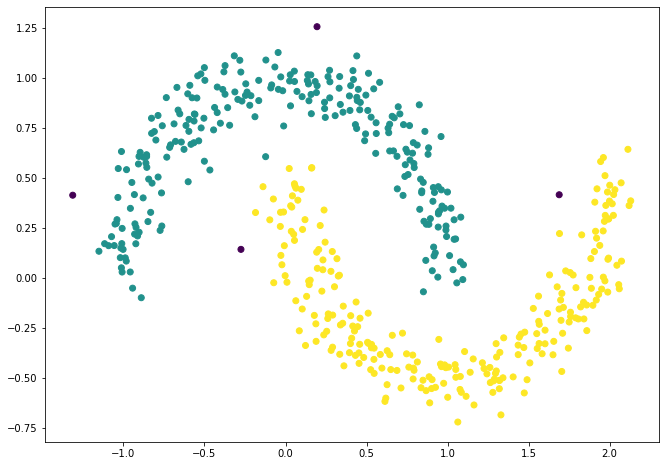

In [12]:
dbscan = DBSCAN(eps=0.2, min_samples=10)
clusters = dbscan.fit_predict(X)

plt.scatter(X[:,0], X[:,1], c=clusters)
plt.show()

Как вы думаете, почему так выходит? (Пояснения ниже)

In [ ]:
X, y = make_circles(n_samples=500, noise=0.05, factor=0.5)

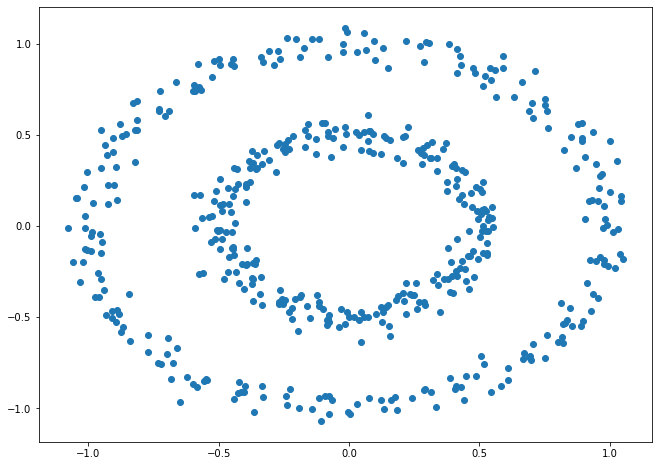

In [ ]:
plt.scatter(X[:,0], X[:,1])
plt.show()

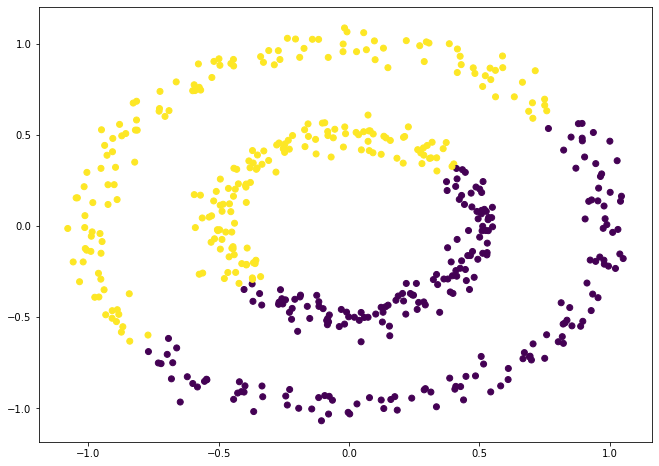

In [ ]:
k_means = KMeans(n_clusters = 2)
k_means = k_means.fit(X)
clusters = k_means.predict(X)
plt.scatter(X[:,0], X[:,1], c=clusters)
plt.show()

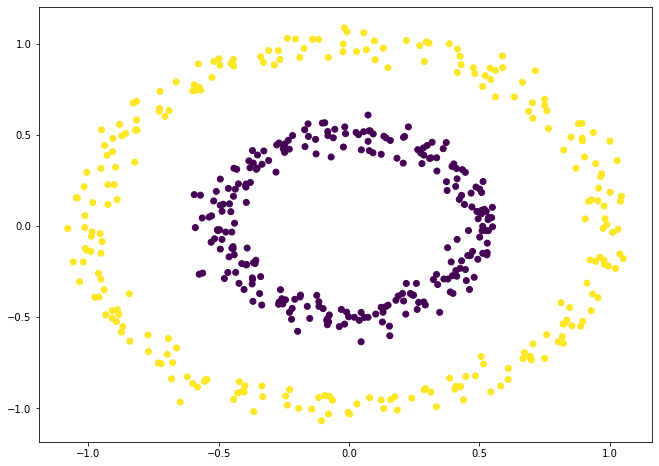

In [ ]:
dbscan = DBSCAN(eps=0.2, min_samples=10)
clusters = dbscan.fit_predict(X)

plt.scatter(X[:,0], X[:,1], c=clusters)
plt.show()

k-Means выделяет только выпуклые кластеры, сходного размера. Не очень хорошо работает с шумными данными. Хуже видит аномалии. С другой стороны, k-means лучше справляется с большими данными и размерностью, а также разреженными данными с переменной плотностью (DBSCAN скорее относит разные плотности к разным кластерам).

[Здесь](https://scikit-learn.ru/clustering/) можно посмотреть на примеры работы других методов кластеризации.